<a href="https://colab.research.google.com/github/VincentPetitPro/M1-ML-assignements/blob/master/Project_Tennis_Match_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The data
The website http://tennis-data.co.uk/alldata.php gathers outcomes of both WTA (Women Tennis Association) and ATP (Association of Tennis Professionals - men only) tennis games over several years.

A short description of each variable can be found here :
http://www.tennis-data.co.uk/notes.txt

In [ ]:

# Added on 04/04/2022: with the current versions of the libs installed in Colab, we get an error 
# "ImportError: Pandas requires version '1.2.0' or newer of 'xlrd' (version '1.1.0' currently installed)."
# We have to upgrade pandas in order to tackle that issue
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.4 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')
from datetime import *
import re
import random
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


SEED=1000

## Helpers

In [ ]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset
Executing the cell below should provide you with :
- one pandas dataframe for all ATP matches ( df_atp )
- one pandas dataframe for all WTA matches ( df_wta )

In [ ]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))


INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

In [ ]:
df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
INFO:root:52298 matches ATP in df_atp
INFO:root:29581 matches WTA in df_wta


# Cleaning the Dataset from String values

In [ ]:
def toNumeric(value):
    return pd.to_numeric(value, errors='coerce')


# Clean a row having a str "`1" instead of int 1
df_atp.loc[df_atp['Lsets'] == '`1', 'Lsets'] = 1

# Put NaN instead of empty string in the men and women data
for col in ['W2', 'L2', 'W3', 'L3', 'L4', 'W4', 'W5', 'L5']:
    df_atp.loc[df_atp[col] == ' ', col] = float('NaN')
    df_wta.loc[df_atp[col] == ' ', col] = float('NaN')

# Replaces all non numeric to 0

for col in ['B365W', 'B365L', 'B&WW', 'B&WL', 'CBW', 'CBL', 'EXW', 'EXL', 'LBW', 'LBL', 'GBW', 'GBL', 'IWW', 'IWL',
            'PSW', 'PSL', 'SBW', 'SBL', 'SJW', 'SJL', 'UBW', 'UBL']:
    df_atp[col] = df_atp.apply(
        lambda row: toNumeric(row[col]), axis=1
    )

# Question 1 - 2 points
Who are the three ATP players with the most wins ?

In [ ]:
print(df_atp['Winner'].value_counts().head(3))

Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64


# Question 2 - 2 points
How many sets did the player “ Federer R.” win in total ?

In [ ]:
print(int(df_atp[df_atp.Winner=='Federer R.']['Wsets'].sum() + df_atp[df_atp.Loser=='Federer R.']['Wsets'].sum()))

3064


# Question 3 - 2 points
How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?

In [ ]:
print(int(df_atp[df_atp.Winner=='Federer R.'][df_atp.Date >= '2016-01-01'][df_atp.Date <= '2017-12-31']['Wsets'].sum() + df_atp[df_atp.Loser=='Federer R.'][df_atp.Date >= '2016-01-01'][df_atp.Date <= '2017-12-31']['Wsets'].sum()))

199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


# Question 4 - 2 points
For each match, what is the percentage of victories of the winner in the past ?

In [ ]:
def previous_w_percentage(row, dictWin):
    # Init the dict value for the 2 players if it doesn't already exist
    if (not (row['Winner'] in dictWin)):
        dictWin[row['Winner']] = {'wins': 0, 'losses': 0}
    if (not row['Loser'] in dictWin):
        dictWin[row['Loser']] = {'wins': 0, 'losses': 0}

    # We want the previous not current %
    perc = float('NaN')
    # No losses = 100% = 1
    if ((dictWin[row['Winner']]['wins'] + dictWin[row['Winner']]['losses']) < 2):
        perc = float('NaN')
    elif (dictWin[row['Winner']]['losses'] == 0):
        perc = 1
    else:
        # Compute the percentage only after the first match
        perc = dictWin[row['Winner']]['wins'] / (dictWin[row['Winner']]['losses'] + dictWin[row['Winner']]['wins'])

    # Keeping track of the wins/losses
    dictWin[row['Winner']]['wins'] += 1
    dictWin[row['Loser']]['losses'] += 1

    # Percentage
    return perc


def answerFour(df):
    dictWin = {}
    df["winner_previous_win_percentage"] = df.apply(
        lambda row: previous_w_percentage(
            row,
            dictWin
        ),
        axis=1  # Axis is 'columns' or 1 so index is the columns and we get the rows
    )

    return df

In [ ]:
answerFour(df_wta)

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,...,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,winner_previous_win_percentage
0,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Sun T.T.,...,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Dulko G.,...,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Loit E.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Craybas J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Bartoli M.,...,4.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29576,59,Zhuhai,WTA Elite Trophy,2018-11-02,Tour Championships,Indoor,Hard,Round Robin,3,Muguruza G.,...,NaN,NaN,NaN,NaN,NaN,2.05,2.06,1.88,1.95,0.634921
29577,59,Zhuhai,WTA Elite Trophy,2018-11-02,Tour Championships,Indoor,Hard,Round Robin,3,Wang Q.,...,NaN,NaN,NaN,NaN,NaN,2.55,1.66,2.41,1.58,0.513889
29578,59,Zhuhai,WTA Elite Trophy,2018-11-03,Tour Championships,Indoor,Hard,Semifinals,3,Barty A.,...,NaN,NaN,NaN,NaN,NaN,2.10,1.95,1.96,1.87,0.611111
29579,59,Zhuhai,WTA Elite Trophy,2018-11-03,Tour Championships,Indoor,Hard,Semifinals,3,Wang Q.,...,NaN,NaN,NaN,NaN,NaN,2.45,1.72,2.25,1.67,0.517241


In [ ]:
answerFour(df_atp)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,winner_previous_win_percentage
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,NaN,NaN,NaN,NaN,NaN,1.44,3.40,1.38,3.14,0.664032
52294,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,...,NaN,NaN,NaN,NaN,NaN,1.22,6.03,1.17,5.14,0.829876
52295,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Zverev A.,...,NaN,NaN,NaN,NaN,NaN,3.40,1.45,3.14,1.38,0.665354
52296,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Djokovic N.,...,NaN,NaN,NaN,NaN,NaN,1.15,7.72,1.12,6.52,0.830052


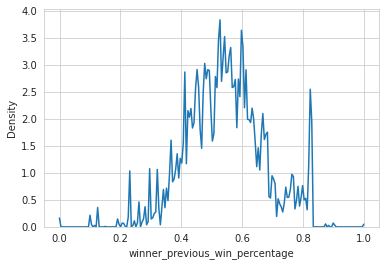

In [ ]:
sns.kdeplot(data=df_atp, x='winner_previous_win_percentage', bw_adjust=0.01)

# Question 5 - 12 points
Please predict the outcome for each ATP tennis game during the year 2017.
Your notebook should handle:
- the data preparation process
- the modeling phase
- the evaluation of your model(s)
- any observation or explanation you deem interesting

Bonus points if :
- your notebook contains graphics that are both interesting and pretty
- The code is clear and well explained

# Features

## Players Features

In the dataset, we have a Winner and Looser, with associated L and W columns. This present a data leakage, so we want fo fix that.

We want to remove the notion of loser and winner, and instead have players and a feature for which player in the winner.

All columns are now simply for P1 or P2, which is selected randomly.

In [ ]:
def retrievePlayer(row):
    list = [row['Winner'], row['Loser']]

    return random.choice(list)


def winner(name, row):
    return name == row['Winner']


def numberGameWon(name, row):
    return 1 if winner(name, row) else 0


def playerStatistics(name, row):
    return row['WPts'] if winner(name, row) else row['LPts']


def playerRank(name, row):
    return row['WRank'] if winner(name, row) else row['LRank']


def playerOdds(name, row):
    percSum = 0
    total = 0

    if winner(name, row):
        for col in ['B365W', 'B&WW', 'CBW', 'EXW', 'LBW', 'GBW', 'IWW', 'PSW', 'SBW', 'SJW', 'UBW']:
            if (col in row and not (math.isnan(row[col]))):
                percSum += row[col]
                total += 1
    else:
        for col in ['B365L', 'B&WL', 'CBL', 'EXL', 'LBL', 'GBL', 'IWL', 'PSL', 'SBL', 'SJL', 'UBL']:
            if (col in row and not (math.isnan(row[col]))):
                percSum += row[col]
                total += 1

    if (total == 0):
        return float('nan')

    return percSum / total


def getOpponentName(name, row):
    return row['Loser'] if winner(name, row) else row['Winner']

## Data Prep

Reprends les coms du code ci-dessous

In [ ]:
##  Step 1 is to determine the columns from the prior observations we wish to maintain.
data = df_atp[
  ['Date', 'Comment', 'Series', 'Surface', 'Round', 'Court', 'B365L', 'B365W', 'PSL', 'PSW', 'EXL', 'EXW', 'LPts',
  'LRank', 'Loser', 'WRank', 'WPts', 'Winner', 'Tournament', 'Best of']]

#data.fillna(0, inplace=True)
data.dropna(subset=['Date'])
data = data.drop(data[data.WRank == 'NR'].index)
data = data.drop(data[data.LRank == 'NR'].index)

## Step 2 is to create columns for predilections

### We add a column for the player 1
data['P1Name'] = data.apply(
   lambda row: retrievePlayer(row), axis=1
)

### And we add a column for the wins of player 1
data['P1Won'] = data.apply(
    lambda row: numberGameWon(row['P1Name'], row), axis=1
)

### After that we create two columns for the statistics of the players
data['P1Points'] = data.apply(
    lambda row: playerStatistics(row['P1Name'], row), axis=1
)
data['P1Rank'] = data.apply(
    lambda row: playerRank(row['P1Name'], row), axis=1
)
data['P1Odds'] = data.apply(
    lambda row: playerOdds(row['P1Name'], row), axis=1
)

### And we do the same for the opponent
data['P2Name'] = data.apply(
    lambda row: getOpponentName(row['P1Name'], row), axis=1
)
data['P2Points'] = data.apply(
    lambda row: playerStatistics(row['P2Name'], row), axis=1
)
data['P2Rank'] = data.apply(
    lambda row: playerRank(row['P2Name'], row), axis=1
)
data['P2Odds'] = data.apply(
    lambda row: playerOdds(row['P2Name'], row), axis=1
)

# And we can obtain the training dataset df
df_atp_renamed = data[
    ['Date', 'Series', 'Surface', 'Court', 'Round', 'P1Odds', 'P2Odds', 'PSL', 'PSW', 'P1Name', 'P2Name',
    'P2Points', 'P2Rank', 'P1Points', 'P1Rank', 'P1Won', 'Tournament', 'Best of']]

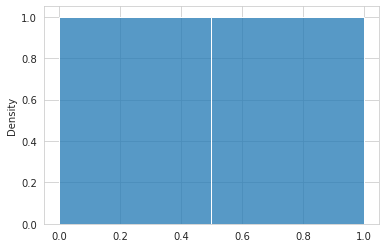

In [ ]:
sns.histplot(data=df_atp_renamed['P1Won'], stat='density', x=[0, 1])

Here we managed to check if the values are randomized correctly.

###Generation of binary data 

The dataset contains several features that we transform to binary values. 
- The surface has a variety of distinct values. 
- Round has a variety of distinct values. 
- The court has two distinct values.

In [ ]:
prefix = '_'

dummies = pd.get_dummies(df_atp_renamed, columns=np.array(['Surface', 'Round']), prefix=['Surface', 'Round'],
                         prefix_sep=prefix)
dummy = pd.get_dummies(df_atp_renamed, columns=np.array(['Court']), prefix=['Court'], prefix_sep=prefix,
                       drop_first=True)

# Obtain the one-of-a-kind values that will distinguish the dummies
round = df_atp['Round'].unique()
round = list(map(lambda x: 'Round' + prefix + x, round))
surface = df_atp['Surface'].unique()
surface = list(map(lambda x: 'Surface' + prefix + x, surface))
court = df_atp['Court'].unique()
court = list(map(lambda x: 'Court' + prefix + x, court))

# Names of all newly formed categories
categories = round + surface
print(categories)

# All but the dummies' columns should be removed.
roundDummies = dummies.loc[:, pd.Index(categories)]
roundDummy = dummy.loc[:, 'Court_Outdoor']

# We now merge the dummies in the df
df_atp_with_dummies = pd.concat([df_atp_renamed, roundDummies, roundDummy], axis=1)

# And remove all sources columns
df_atp_with_dummies.drop(axis=1, columns=['Court', 'Surface', 'Round'], inplace=True)
df_atp_with_dummies

['Round_1st Round', 'Round_2nd Round', 'Round_Quarterfinals', 'Round_Semifinals', 'Round_The Final', 'Round_3rd Round', 'Round_4th Round', 'Round_Round Robin', 'Surface_Hard', 'Surface_Clay', 'Surface_Grass', 'Surface_Carpet']


,Date,Series,P1Odds,P2Odds,PSL,PSW,P1Name,P2Name,P2Points,P2Rank,...,Round_Semifinals,Round_The Final,Round_3rd Round,Round_4th Round,Round_Round Robin,Surface_Hard,Surface_Clay,Surface_Grass,Surface_Carpet,Court_Outdoor
0,2000-01-03,International,NaN,NaN,NaN,NaN,Dosedel S.,Ljubicic I.,NaN,77.0,...,0,0,0,0,0,1,0,0,0,1
1,2000-01-03,International,NaN,NaN,NaN,NaN,Enqvist T.,Clement A.,NaN,56.0,...,0,0,0,0,0,1,0,0,0,1
2,2000-01-03,International,NaN,NaN,NaN,NaN,Baccanello P.,Escude N.,NaN,40.0,...,0,0,0,0,0,1,0,0,0,1
3,2000-01-03,International,NaN,NaN,NaN,NaN,Knippschild J.,Federer R.,NaN,65.0,...,0,0,0,0,0,1,0,0,0,1
4,2000-01-03,International,NaN,NaN,NaN,NaN,Woodbridge T.,Fromberg R.,NaN,81.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,2018-11-16,Masters Cup,3.273333,1.380000,3.22,1.40,Isner J.,Zverev A.,5085.0,5.0,...,0,0,0,0,1,1,0,0,0,0
52294,2018-11-16,Masters Cup,1.196667,5.076667,5.23,1.20,Djokovic N.,Cilic M.,4050.0,7.0,...,0,0,0,0,1,1,0,0,0,0
52295,2018-11-17,Masters Cup,3.213333,1.396667,1.41,3.24,Zverev A.,Federer R.,6020.0,3.0,...,1,0,0,0,0,1,0,0,0,0
52296,2018-11-17,Masters Cup,1.123333,7.240000,7.72,1.12,Djokovic N.,Anderson K.,4310.0,6.0,...,1,0,0,0,0,1,0,0,0,0


# Data Splitting

We divided the data into two categories: training and testing: 


* Practice: all other matches
* Test: matches in 2017



In [ ]:
def cleanColumns():
    # We have to filter all the test results
    return [
               'Best of',
               'Date',
               'Series',
               'Tournament',
               'P2Points',
               'P2Rank',
               'P2Name',
               'P1Points',
               'P1Rank',
               'P1Name',
               'P1Won',
               'P1Odds', 'P2Odds',
           ] + ['Round_1st Round', 'Round_2nd Round', 'Round_Quarterfinals', 'Round_Semifinals', 'Round_The Final',
                'Round_3rd Round', 'Round_4th Round', 'Round_Round Robin', 'Surface_Hard', 'Surface_Clay',
                'Surface_Grass', 'Surface_Carpet', 'Court_Outdoor']


def timeFrameTrain(df):
    return df.loc[(df['Date'] < '2017-01-01'), cleanColumns()]


def timeFrameTest(df):
    return df.loc[(df['Date'] >= '2017-01-01') & (df['Date'] < '2018-01-01'), cleanColumns()]

In [ ]:
df_atp_train = timeFrameTrain(df_atp_with_dummies)
df_atp_test = timeFrameTest(df_atp_with_dummies)
df_atp_train.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


,Best of,Date,Series,Tournament,P2Points,P2Rank,P2Name,P1Points,P1Rank,P1Name,...,Round_Semifinals,Round_The Final,Round_3rd Round,Round_4th Round,Round_Round Robin,Surface_Hard,Surface_Clay,Surface_Grass,Surface_Carpet,Court_Outdoor
count,47000.000000,47000,47000,47000,30796.000000,46956.000000,47000,30800.000000,46958.000000,47000,...,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000
unique,NaN,4087,8,206,NaN,NaN,1144,NaN,NaN,1171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2002-01-14 00:00:00,International,US Open,NaN,NaN,Federer R.,NaN,NaN,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,127,12181,2159,NaN,NaN,593,NaN,NaN,641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2000-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-11-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.371191,NaN,NaN,NaN,1431.677004,75.597964,NaN,1448.145325,75.719622,NaN,...,0.047830,0.023915,0.070979,0.016681,0.006894,0.525426,0.328064,0.110468,0.036043,0.819021
std,0.777568,NaN,NaN,NaN,1914.057343,100.154470,NaN,1933.080823,97.889326,NaN,...,0.213408,0.152786,0.256792,0.128074,0.082742,0.499358,0.469513,0.313476,0.186398,0.385005
min,3.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,NaN,NaN,NaN,551.000000,24.000000,NaN,552.000000,24.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# We make the Y series by merely keeping the outcome.
trainY = df_atp_train.loc[:, 'P1Won']
# If we make a mistake with the dataset, we don't have to restart everything.
trainX = df_atp_train.copy(deep=True)
# Replace all NaN values with 0
trainX.fillna(0, inplace=True)
# Clean columns 
trainX.drop(['P1Won', 'Series', 'Tournament', 'Best of', 'P2Name', 'P1Name', 'Date'], axis=1, inplace=True)

testY = df_atp_test.loc[:, 'P1Won']
testX = df_atp_test.copy(deep=True)
testX.fillna(0, inplace=True)
testX.drop(['P1Won', 'Series', 'Tournament', 'Best of', 'P2Name', 'P1Name', 'Date'], axis=1, inplace=True)

trainX

,P2Points,P2Rank,P1Points,P1Rank,P1Odds,P2Odds,Round_1st Round,Round_2nd Round,Round_Quarterfinals,Round_Semifinals,Round_The Final,Round_3rd Round,Round_4th Round,Round_Round Robin,Surface_Hard,Surface_Clay,Surface_Grass,Surface_Carpet,Court_Outdoor
0,0.0,77.0,0.0,63.0,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
1,0.0,56.0,0.0,5.0,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.0,40.0,0.0,655.0,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.0,65.0,0.0,87.0,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
4,0.0,81.0,0.0,198.0,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47023,11185.0,1.0,5115.0,3.0,3.620000,1.270000,0,0,0,0,0,0,0,1,1,0,0,0,0
47024,4705.0,5.0,3450.0,7.0,2.380000,1.560000,0,0,0,0,0,0,0,1,1,0,0,0,0
47025,11185.0,1.0,5050.0,4.0,4.336667,1.206667,0,0,0,1,0,0,0,0,1,0,0,0,0
47026,4705.0,5.0,10780.0,2.0,1.223333,4.210000,0,0,0,1,0,0,0,0,1,0,0,0,0


## Finding the most useful features

We're attempting to determine which characteristics have the greatest impact on the outcomes.

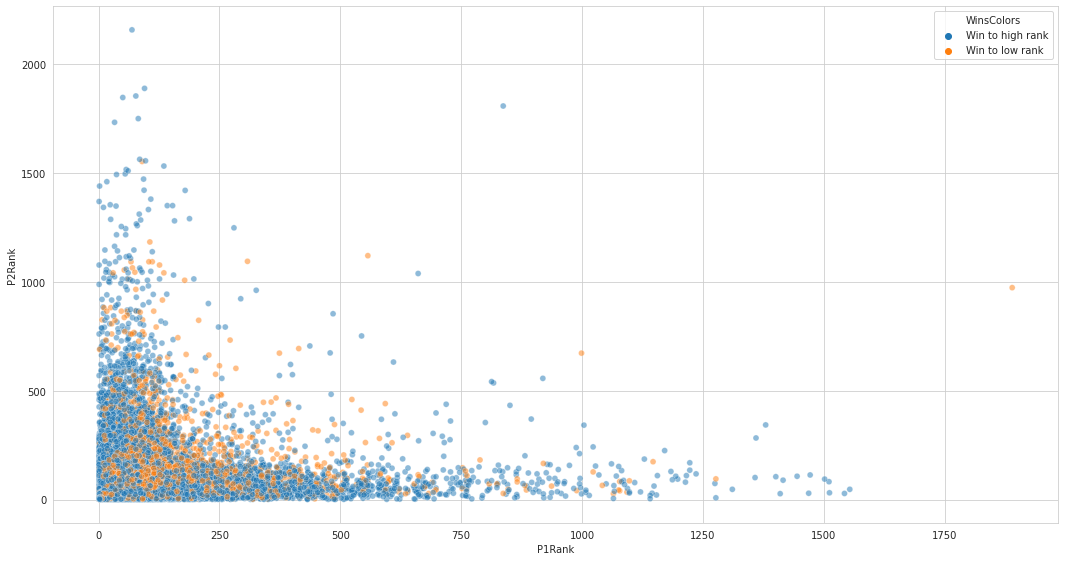

In [ ]:
def setWin(row):
    if row['P1Won']:
        if row['P1Rank'] < row['P2Rank']:
            return 'Win to high rank'
        else:
            return 'Win to low rank'
    else:
        if row['P2Rank'] < row['P1Rank']:
            return 'Win to high rank'
        else:
            return 'Win to low rank'


df_atp_train["WinsColors"] = df_atp_train.apply(
    lambda row: setWin(row),
    axis=1
)

plt.figure(figsize=(18, 9.5))
sns.scatterplot(data=df_atp_train, x='P1Rank', y='P2Rank', hue='WinsColors', alpha=0.5)

# Data Modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
def metrics(train_pred, valid_pred, y_train, y_valid):

    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))

    # Absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)

    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0

    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)

    return train_rmse, valid_rmse, train_mape, valid_mape


def evaluate(model, features, X_train, X_valid, y_train, y_valid):

    # features is a list of columns of X_train and X_valid on which you can make predictions with predict
    train_pred = model.predict(X_train[features])
    # The same thing applies to the valid set
    valid_pred = model.predict(X_valid[features])

    # These metrics are used to determine whether or not the predictions are accurate. 
    # We compare the results: the better the predictions, the lower the metrics are.
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)

    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')
    print('Training score: {:.2f}'.format(rf.score(X_train, y_train)))
    print('Test score: {:.2f}'.format(rf.score(X_valid, y_valid)))

# Algorithm : Random Forest

Random forests is a classification and regression ensemble learning method known to be more precise.

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=SEED, min_samples_leaf=20, n_jobs=-1)

In [ ]:
rf.fit(trainX, trainY)

RandomForestClassifier(min_samples_leaf=20, n_estimators=1000, n_jobs=-1,
                       random_state=1000)

In [44]:
features = trainX.columns

evaluate(rf, features, trainX, testX, trainY, testY)

Training:   rmse = 0.52 	 mape = 21.77
Validation: rmse = 0.58 	 mape = 24.32
Training score: 0.73
Test score: 0.67


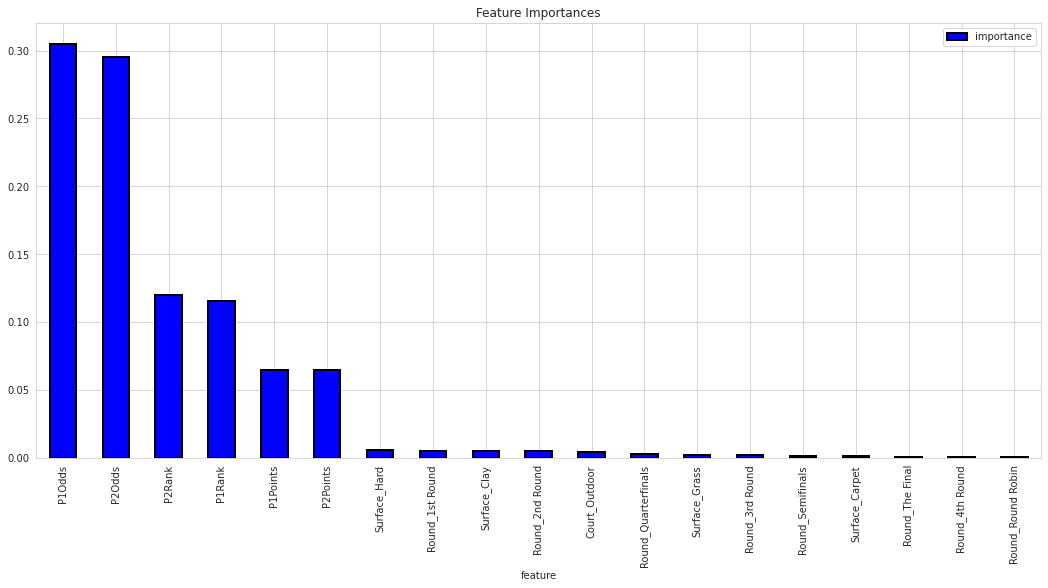

In [45]:
def featuresImportance(model):
    feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_}).sort_values(
        'importance', ascending=False).set_index('feature')
    feature_importances.plot.bar(color='b', edgecolor='k', linewidth=2, figsize=(18, 8));
    plt.title('Feature Importances');


featuresImportance(rf)

We can see that the binary values are not that important here, they could be discarded to reduce overfitting.

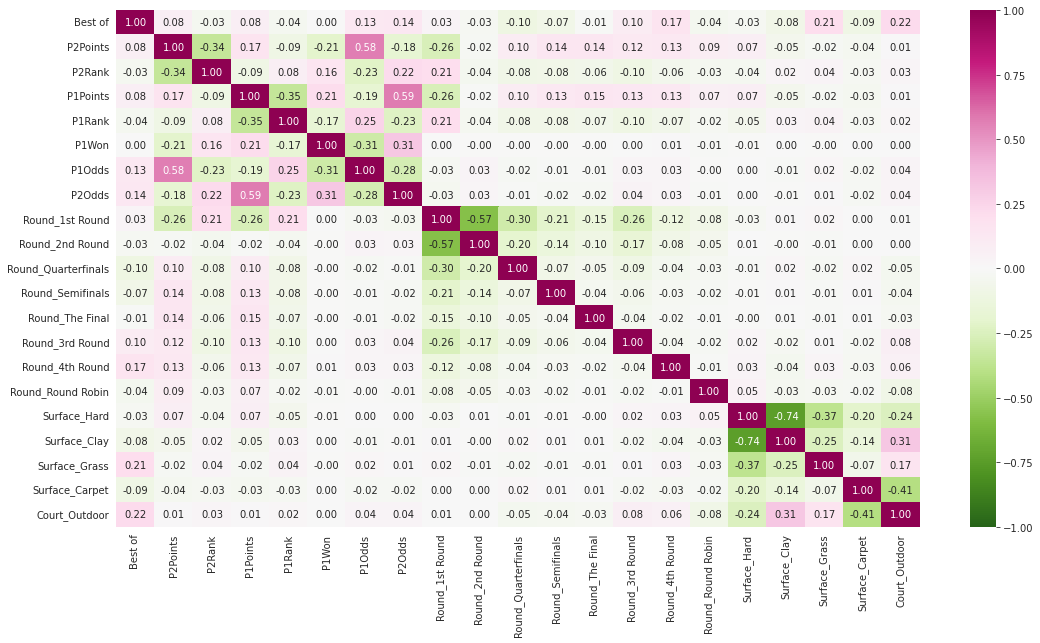

In [46]:
corrs = df_atp_train.corr()

plt.figure(figsize=(18, 9.5))
sns.heatmap(corrs, annot=True, vmin=-1, vmax=1, fmt='.2f', cmap=plt.cm.PiYG_r);

Our features are not too correlated and that is a good thing to prevent bias. The only ones are the Odds and Ranks as it was expected ; Court and  Surfaces are also correlated.

Our characteristics are not to close to each other which means we can reduce our errors. Some of them are still correlated but that represents a minority.

# Conclusion

As you can see we only get roughly 67.1% accuracy on our testing set and 73% accuracy on our training set. 

We found multiple points of improvements on our work.
* We tried to do some fine tuning without being successful and the results presented here are our best shot. But we can improve on this.
* We could use more data to improve accuracy. Our dataset is of small size compared to real professional datasets.
* The datasets contain irregularities, errors and false values. If we could have a more precise and clean dataset that would help us a lot in improving our results.
